# House Price Prediction

This is a simple demo showing most of the typical functionality in a MLP implemented in PyTorch. Used data is from [Kaggle](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction).

## Data Description

Most of the fields are self-explanatory, only the ones that require more information are described in the following sections.

## Building Grades

* **1-3** Falls short of minimum building standards. Normally cabin or inferior structure.
* **4** Generally older, low quality construction. Does not meet code.
* **5** Low construction costs and workmanship. Small, simple design.
* **6** Lowest grade currently meeting building code. Low quality materials and simple designs.
* **7** Average grade of construction and design. Commonly seen in plats and older sub-divisions.
* **8** Just above average in construction and design. Usually better materials in both the exterior and interior finish work.
* **9** Better architectural design with extra interior and exterior design and quality.
* **10** Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.
* **11** Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.
* **12** Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.
* **13** Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

`zipcode`, `lat` (latitude) and `lon` (longitude) need to be treated as categorical data, since these cannot be ordered in any meaningful way. In this exaple we only use the zipcodes and embed these into an embedding vector. The idea being that this way the network learns how different zipcodes contribute to the price.

In [1]:
import os
import shutil
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear, Parameter, ReLU, BatchNorm1d, LeakyReLU, Sigmoid, Dropout
from torch.optim.lr_scheduler import StepLR
import numpy as np
import opendatasets as od
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from typing import Tuple, List

In [2]:
class HouseDataset(Dataset):
    def __init__(self, datadir: str = "./data/housesalesprediction"):
        """
        Parameters
        ----------
        datadir : str
            Directory where the data is stored / downloaded.
        columns : list
            Names of columns that are kept, everything else is dropped. If None, all the columns are kept
        """

        self.datadir = datadir
        self.filename = "kc_house_data.csv"
        self.path_to_file = os.path.join(self.datadir, self.filename)

        # Download if the datafile does not exist
        if not os.path.isfile(self.path_to_file):
            od.download("https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/download?datasetVersionNumber=1")
            shutil.move("./housesalesprediction/", self.datadir)

        # Read in the csv file
        self.data = pd.read_csv(self.path_to_file)
        
        # Numerical features
        feature_list = ["bedrooms", "bathrooms", "condition", "grade", "sqft_living", "sqft_lot", "sqft_above", "sqft_basement", "waterfront", "view"]
        for feature in feature_list:
            if feature not in self.data.columns:
                raise Exception(f"'{feature}' does not exist in self.data")

        self.numerical_features = self.data[feature_list]

        # Categorical features
        self.zip_feature = self.data["zipcode"]

        # Price
        self.price = self.data["price"]

        # Store the column names
        self.column_names = []
        for col in self.numerical_features.columns:
            self.column_names.append(col)

        # Convert features and prices to numpy arrays
        numerical_features_numpy = self.numerical_features.to_numpy(dtype=np.float32)
        zip_feature_numpy = self.zip_feature.to_numpy(dtype=np.int32).reshape(-1, 1)
        prices_numpy = self.price.to_numpy(dtype=np.float32).reshape(-1, 1)

        # Numerical feature scaler, fit and transform
        self.numerical_feature_scaler = StandardScaler()
        numerical_features_numpy = self.numerical_feature_scaler.fit_transform(numerical_features_numpy)

        # Price scaler, fit and transform
        self.price_scaler = StandardScaler()
        prices_numpy = self.price_scaler.fit_transform(prices_numpy)

        # zip-code scaler, fit and transform
        self.zip_code_scaler = OrdinalEncoder(dtype=np.int32)
        zip_feature_numpy = self.zip_code_scaler.fit_transform(zip_feature_numpy)
        self.nr_zip_categories = int(max(zip_feature_numpy.flatten()) + 1)

        # Convert to tensors for faster access
        self.numerical_data_tensor = torch.from_numpy(numerical_features_numpy)
        self.zip_data_tensor = torch.from_numpy(zip_feature_numpy)
        self.price_tensor = torch.from_numpy(prices_numpy)

    def __len__(self) -> int:
        """
        Get length of the data set.

        Returns
        -------
        int
            number of elements in the data set
        """
        return self.numerical_data_tensor.shape[0]

    def __getitem__(self, idx: int) -> Tuple[torch.tensor, torch.tensor, torch.tensor]:
        """
        Get an item from the data set.

        Parameters
        ----------
        ids : int
            index to the data to be returned

        Returns
        -------
        numerical_data_tensor : torch.tensor
            Tensor containing the numerical values
        zip_data_tensor : torch.tensor
            Categorical zip data (i.e. an index to embedding)
        price: torch.tensor
            House price
        """
        return self.numerical_data_tensor[idx, :], self.zip_data_tensor[idx, :], self.price_tensor[idx]
    
    def get_nr_zip_categories(self) -> int:
        """
        Get number of zip code categories.

        Returns
        -------
        int
            Number of zip categories
        """
        return self.nr_zip_categories

    def get_column_names(self) -> List[str]:
        """
        Returns column names of the numerical data.

        Returns
        -------
        list
            List containing the column names
        """
        return self.column_names

    def get_column_values(self, column_name: str) -> np.ndarray:
        """
        Returns values for a given column in the original data.

        Parameters
        ----------
        column_name : str
            Name of the column which values are returned (without scaling)

        Returns
        -------
        np.ndarray
            Original values for the chosen column
        """
        return self.data[column_name].values

    def transform_numerical_features(self, x: np.ndarray) -> np.ndarray:
        """
        Transform features to have a mean of 0.0 and std of 1.0. Scaler
        parameters are based on the original dataset.

        Parameters
        ----------
        x : np.ndarray
            Array to be transformed

        Returns
        -------
        np.ndarray
            Transformed features
        """
        return self.numerical_feature_scaler.transform(x)

    def inverse_transform_numerical_features(self, x: np.ndarray) -> np.ndarray:
        """
        Inverse transforms features back to the original space.

        Parameters
        ----------
        x : np.ndarray
            Array to be transformed

        Returns
        -------
        np.ndarray
            Inverse transformed features
        """
        return self.numerical_feature_scaler.inverse_transform(x)

    def transform_zip_codes(self, x: np.ndarray) -> np.ndarray:
        """
        Encodes zip codes into cetegories (indices).

        Parameters
        ----------
        x : np.ndarray
            Zip codes

        Returns
        -------
        np.ndarray
            Encoded zip code values
        """
        return self.zip_code_scaler.transform(x)

    def inverse_transform_zip_codes(self, x: np.ndarray) -> np.ndarray:
        """
        Decodes encoded zip codes back into zip codes.

        Parameters
        ----------
        x : np.ndarray
            Encoded zip codes

        Returns
        -------
        np.ndarray
            Original zip codes
        """
        return self.numerical_feature_scaler.inverse_transform(x)

    def transform_prices(self, x: np.ndarray) -> np.ndarray:
        """
        Transform prices to have a mean of 0.0 and std of 1.0. Scaler
        parameters are based on the original dataset.

        Parameters
        ----------
        x : np.ndarray
            Array to be transformed

        Returns
        -------
        np.ndarray
            Transformed prices
        """
        return self.price_scaler.transform(x)

    def inverse_transform_prices(self, x: np.ndarray) -> np.ndarray:
        """
        Inverse transform prices back to the original space.

        Parameters
        ----------
        x : np.ndarray
            Array to be transformed

        Returns
        -------
        np.ndarray
            Inverse transformed prices
        """
        return self.price_scaler.inverse_transform(x)
    
    def get_original_data(self) -> pd.DataFrame:
        """
        Returns the original Pandas DataFrame.

        Returns
        -------
        pd.DataFrame
            Original data
        """
        return self.data

In [3]:
def init_weights(module):
    if isinstance(module, torch.nn.Linear):
        torch.nn.init.normal_(module.weight, mean=0.0, std=1.0)
        if module.bias is not None:
            torch.nn.init.normal_(module.bias, mean=0.0, std=10.0)


class SimpleModel(torch.nn.Module):
    def __init__(self, nr_numerical_features: int, nr_zip_categories: int, embedding_dim: int, dropout_prob: float = 0.5):
        super(SimpleModel, self).__init__()
        """
        Initializes the model.

        Parameters
        ----------
        nr_numerical_features : int
            Number of features in the numerical data
        
        nr_zip_categories : int
            Number of zipcode categories (indices)
        
        embedding_dim : int
            Length of the embedding vector for the zip codes.
        
        Return
        ------
        None
        """

        # Zip code "category" embedding
        self.zip_code_embedding = torch.nn.Embedding(num_embeddings=nr_zip_categories, embedding_dim=embedding_dim)

        # Backbone takes both the zip code embeddings + numerical features as input
        self.model = torch.nn.Sequential(
            Linear(nr_numerical_features + embedding_dim, 100),
            BatchNorm1d(100),
            LeakyReLU(),
            Dropout(dropout_prob),
            Linear(100, 75),
            BatchNorm1d(75),
            LeakyReLU(),
            Dropout(dropout_prob),
            Linear(75, 50),
            BatchNorm1d(50),
            LeakyReLU(),
            Dropout(dropout_prob),
            Linear(50, 1)
        )

        self.model.apply(init_weights)

    def forward(self, numeric_features: torch.tensor, zip_codes: torch.tensor) -> torch.tensor:
        """
        Does inference based on the given input and returns the result.

        Parameters
        ----------
        numeric_features : torch.tensor
            Numerical features

        zip_codes : torch.tensor
            Encoded zip codes (indices)

        Returns
        -------
        torch.tensor
            Estimated house price
        """

        # Calculate embedding for the zip code
        zip_embedding = self.zip_code_embedding(zip_codes).squeeze(1)

        # Concatenate both the numeric features and the zip code embedding vector
        x = torch.cat((numeric_features, zip_embedding), dim=-1)

        return self.model(x)

    def save(self, path: str = "SimpleModel_weights.pth"):
        """
        Save the model.

        Parameters
        ----------
        path : str
            Path to save the model to.
        """
        torch.save(self.state_dict(), path)

    def load(self, path: str = "SimpleModel_weights.pth"):
        """
        Load the model weights.

        Parameters
        ----------
        path : str
            Path to load the model weights from.
        """
        self.load_state_dict(torch.load(path))

In [4]:
# Create a dataset and split it into training- and test sets
dataset = HouseDataset()
print(dataset.get_column_names())
train_set, validation_set, test_set = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True, prefetch_factor=4, num_workers=10)
validation_loader = DataLoader(validation_set, batch_size=batch_size, prefetch_factor=4, num_workers=10)
test_loader = DataLoader(test_set, batch_size=batch_size, prefetch_factor=4, num_workers=10)

['bedrooms', 'bathrooms', 'condition', 'grade', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'waterfront', 'view']


In [5]:
# Create the model, optimizer and the loss function
nr_numerical_features = len(dataset.get_column_names())
nr_zip_categories = dataset.get_nr_zip_categories()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Nr. numerical features: {nr_numerical_features}")
print(f"Nr. zip categories: {nr_zip_categories}")
print(f"Device: {device}")

model = SimpleModel(nr_numerical_features=nr_numerical_features, nr_zip_categories=nr_zip_categories, embedding_dim=15, dropout_prob=0.1)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss()

print(f"Size of the training data set: {len(train_set)}")
print(f"Size of the validation data set: {len(validation_set)}")

Nr. numerical features: 10
Nr. zip categories: 70
Device: cuda
Size of the training data set: 17291
Size of the validation data set: 2161


In [6]:
num_epochs = 200

training_losses = []
validation_losses = []

print("")
print("--- Starting training ---")

for epoch in range(num_epochs):

    training_loss = []
    validation_loss = []

    model.train()
    for step, (numeric_features, zip_codes, price) in enumerate(train_loader):
        numeric_features = numeric_features.to(device)
        zip_codes = zip_codes.to(device)
        price = price.to(device)

        # Forward pass
        output = model(numeric_features, zip_codes)
        loss = loss_function(output, price)
        training_loss.append(loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loss
    model.eval()
    with torch.no_grad():
        for step, (numeric_features, zip_codes, price) in enumerate(validation_loader):
            numeric_features = numeric_features.to(device)
            zip_codes = zip_codes.to(device)
            price = price.to(device)

            # Forward pass
            output = model(numeric_features, zip_codes)
            loss = loss_function(output, price)
            validation_loss.append(loss.item())

    training_losses.append(np.mean(training_loss))
    validation_losses.append(np.mean(validation_loss))

    if (epoch) % 10 == 0:
        print(f"Epoch: {epoch}/{num_epochs}, training loss: {training_losses[-1]}, validation loss: {validation_losses[-1]}")


--- Starting training ---
Epoch: 0/200, training loss: 12.7758819801781, validation loss: 2.2009274924502655
Epoch: 10/200, training loss: 0.9243147226937143, validation loss: 0.2780274777289699
Epoch: 20/200, training loss: 0.472800598813159, validation loss: 0.1744540888158714
Epoch: 30/200, training loss: 0.325742898886934, validation loss: 0.13422455277074785
Epoch: 40/200, training loss: 0.26054670799152435, validation loss: 0.12647568631698103
Epoch: 50/200, training loss: 0.21364969243312673, validation loss: 0.1144990267999032
Epoch: 60/200, training loss: 0.20078591743958393, validation loss: 0.11713877243592459
Epoch: 70/200, training loss: 0.18066506082281417, validation loss: 0.11314603631549022
Epoch: 80/200, training loss: 0.16481264314968208, validation loss: 0.11046376868205912
Epoch: 90/200, training loss: 0.16190381840256307, validation loss: 0.11423667564111598
Epoch: 100/200, training loss: 0.1448127741330884, validation loss: 0.1132214241387213
Epoch: 110/200, tra

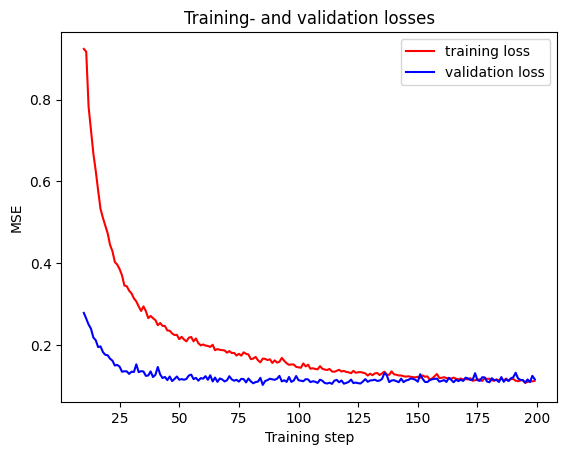

In [7]:
# We skip the first losses in order to get a closer look at the losses when they matter more
start_index = 10
steps = range(len(training_losses))

plt.plot(steps[start_index:], training_losses[start_index:], 'r-', label="training loss")
plt.plot(steps[start_index:], validation_losses[start_index:], 'b-', label="validation loss")
plt.title('Training- and validation losses')
plt.ylabel('MSE')
plt.xlabel('Training step')
plt.legend()
plt.show()

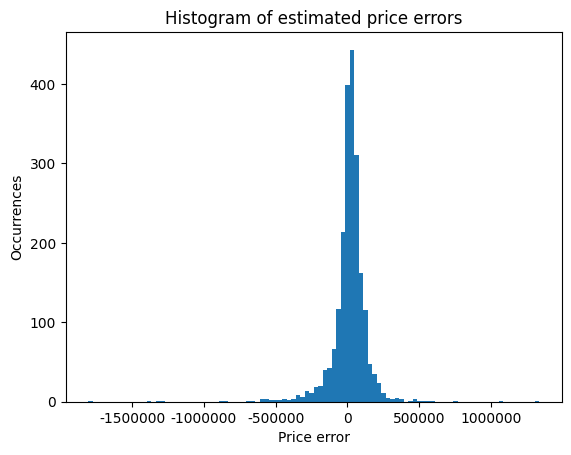

Mean of error: 13503.272877260735
Std of error: 137131.05913771354


In [8]:
# Show histogram of absolute error between the ground truth and the estimated prices
model.eval()
with torch.no_grad():
    def custom_formatter(x, pos):
        return "{:.0f}".format(x)

    # Store the absolute errors, for each batch, to a list
    errors = []
    for numeric_features, zip_codes, prices in test_loader:
        numeric_features = numeric_features.to(device)
        zip_codes = zip_codes.to(device)
        estimated_prices = model(numeric_features, zip_codes)

        estimated_prices = dataset.inverse_transform_prices(estimated_prices.to("cpu"))
        prices = dataset.inverse_transform_prices(prices)
        errors.append(estimated_prices-prices)

    # Concatenate the list into an array
    errors = np.concatenate(errors)

    # Set the custom formatter for the x-axis
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
    plt.title("Histogram of estimated price errors")
    plt.hist(errors, bins=100)
    plt.xlabel("Price error")
    plt.ylabel("Occurrences")
    plt.show()

print(f"Mean of error: {np.mean(errors)}")
print(f"Std of error: {np.std(errors)}")